In [2]:
!pip install xgboost

  Using cached xgboost-3.0.3-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.3-py3-none-win_amd64.whl (149.9 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
df_standard = pd.read_csv('df.eneemr')

https://xgboost.readthedocs.io/en/latest/index.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
df_model = df_standard

X = df_model.select_dtypes(include=['float64', 'int64']).drop(columns=['smurf_flag'])
y = df_model['smurf_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.45, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_pca)[:, 1]))
print("-" * 50)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_pca, y_train)
y_pred_xgb = xgb.predict(X_test_pca)

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test_pca)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       1.00      0.82      0.90       142

    accuracy                           1.00      5649
   macro avg       1.00      0.91      0.95      5649
weighted avg       1.00      1.00      1.00      5649

ROC-AUC: 0.9890190973332276
--------------------------------------------------
XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5507
           1       0.92      0.85      0.88       142

    accuracy                           0.99      5649
   macro avg       0.96      0.92      0.94      5649
weighted avg       0.99      0.99      0.99      5649

ROC-AUC: 0.9854934948349988


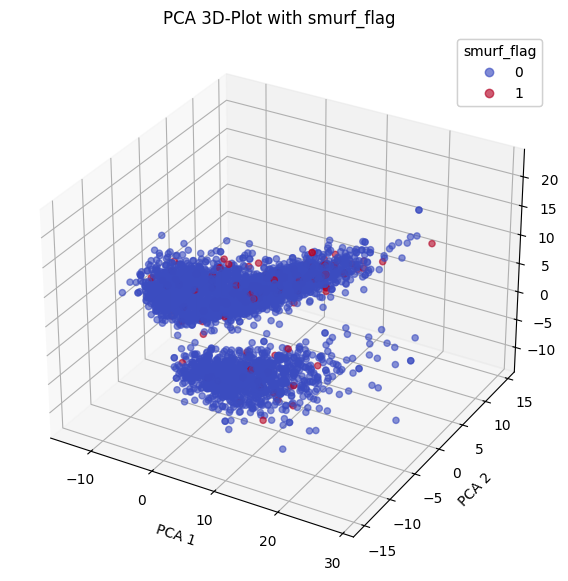

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_test_pca[:,0], X_test_pca[:,1], X_test_pca[:,2], c=y_test, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA 3D-Plot with smurf_flag')
legend1 = ax.legend(*scatter.legend_elements(), title="smurf_flag")
ax.add_artist(legend1)
plt.show()